In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import gpxpy

In [3]:
import pandas as pd
import numpy as np
import datetime

In [4]:
def test_point(point):
    return (point.time != None) &\
           (point.latitude != None) &\
           (point.longitude != None)

In [5]:
def get_df_from_gpx(gpx):
    
    df = pd.DataFrame(columns=['time','lat','lon'])
    times=[]
    stamps=[]
    lats=[]
    lons=[]
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                if test_point(point):
                    times.append(point.time)
                    stamps.append(point.time.timestamp())
                    lats.append(point.latitude)
                    lons.append(point.longitude)
                else: pass
    df = pd.DataFrame(data={'time':times,'timestamp':stamps,'lat':lats,'lon':lons})

    df.sort_values('timestamp', inplace=True)

    df['timestamp'] = df['timestamp'].astype('int')

    df['dtime'] = df.timestamp.values - df.timestamp.min()

    return df

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import matplotlib.dates as mdates

In [8]:
from os import listdir
from os.path import isfile, join
onlyfiles = [join('../gps_data/', f) for f in listdir('../gps_data/') if isfile(join('../gps_data/', f))]

In [9]:
def check_berlin(df):
    berlin_lat = lambda x: 40 <= x <= 60
    berlin_lon = lambda x: 12 <= x <= 14
    
    return (berlin_lon(df.lon.min()) | \
            berlin_lon(df.lon.max())) & \
           (berlin_lat(df.lat.min()) | \
            berlin_lat(df.lat.max()))

In [211]:
#gpxfile = onlyfiles[10] #0 #10 # 6
gpxfile = '../gps_data/2778884.gpx'
gpx = gpxpy.parse(open(gpxfile, 'r'))
df = get_df_from_gpx(gpx)

In [11]:
import folium

colors = ['green','darkgreen','lightgreen','darkblue','lightblue',
          'red','blue','gray','darkred','orange','beige',
          'purple','pink','cadetblue','lightgray','black'] 
# 'lightred','darkpurple'

In [12]:
home_coords = [0.5*(df.lat.max()+df.lat.min()), 0.5*(df.lon.max()+df.lon.min())] 

In [114]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=12, control_scale=True) #

len_colors=len(colors)

lons = df.lon.values
lats = df.lat.values
coords = list(zip(lats,lons))
print(len(coords))

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

2027


In [14]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
projx, projy = proj.transform(crs_wgs, crs_bng, df["lon"].values, df["lat"].values)

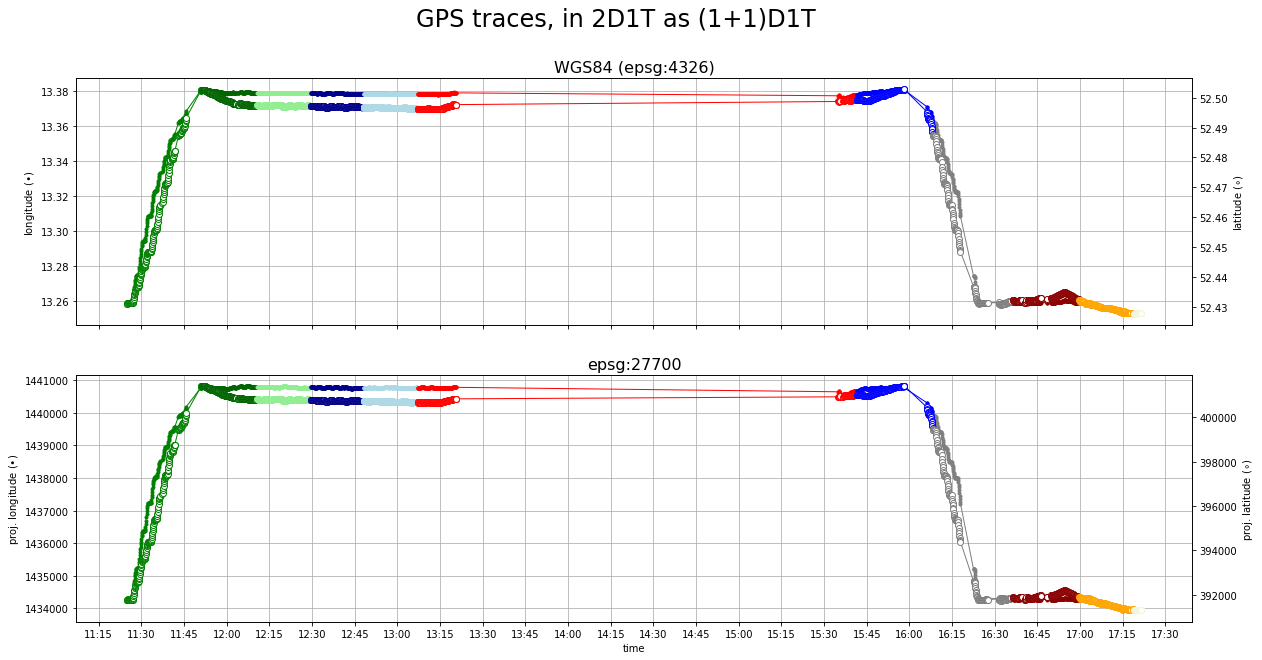

In [20]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df.time.values[nn:nnn], df.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df.time.values[nn:nnn], df.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df.time.values[nn:nnn], projx[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df.time.values[nn:nnn], projy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

### Sparsify and noisify

In [22]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [ ]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments

In [23]:
from synthetic_data.masking import get_mask_with_duplicates

In [37]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [26]:
df.time.count()

2027

In [87]:
mask = get_mask_with_duplicates(df.time.values, 0.1, 0.2, True)

40
Counter({1: 16, 2: 4, 3: 2, 6: 1, 4: 1})
freq 24 40 24

202 162 40 19.8


In [88]:
mask.size

202

In [89]:
from synthetic_data.noise import get_add_noise

In [90]:
map_array = lambda f: lambda x: np.fromiter((f(xi) for xi in x), x.dtype, count=len(x))

#y[mask] = map_array(get_add_noise(noise))(y[mask])

In [99]:

nprojx = map_array(get_add_noise(200.0))(projx[mask])
nprojy = map_array(get_add_noise(200.0))(projy[mask])
ntime = df.time.values[mask].copy()

In [100]:
nprojx.shape, ntime.shape

((202,), (202,))

In [619]:
ntime[0].dtype

dtype('<M8[ns]')

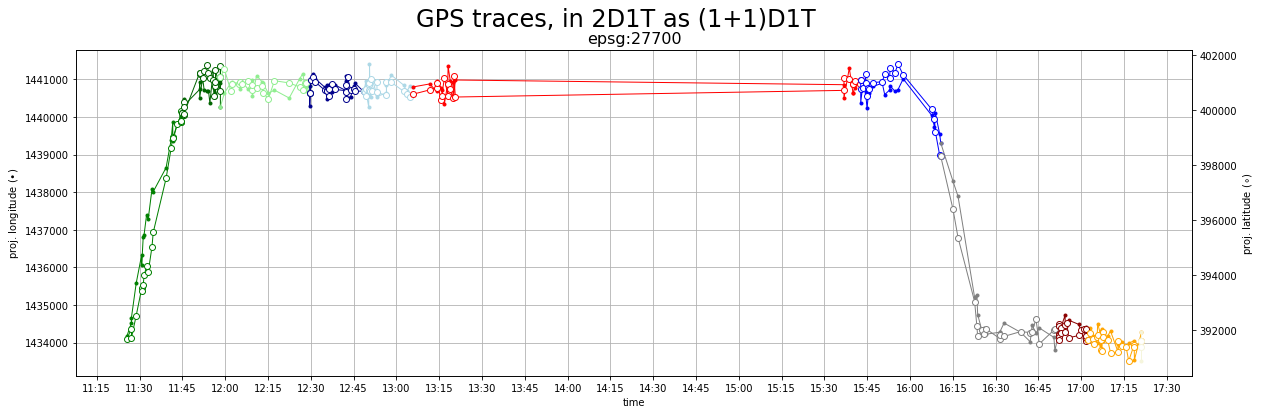

In [104]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax= plt.subplots(1,1, figsize=[20,6])

axt = ax.twinx()

offset = int(nprojx.size*.10)

for n in range(50):
    nn = n*offset
    nnn = (n+1)*offset+1

    ax.plot(ntime[nn:nnn], nprojx[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(ntime[nn:nnn], nprojy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [102]:
# then cast your geographic coordinate pair to the projected system
nlons, nlats = proj.transform(crs_bng, crs_wgs, nprojx, nprojy)

In [106]:
m = folium.Map(location=home_coords, width='60%', height='50%', top='0%',
                   zoom_start=12, tiles='CartoDBpositron', control_scale=True)

len_colors=len(colors)

lons = nlons
lats = nlats
coords = list(zip(lats,lons))
print(len(coords))
offset = int(nprojx.size*.10)
for n in range(50):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

202


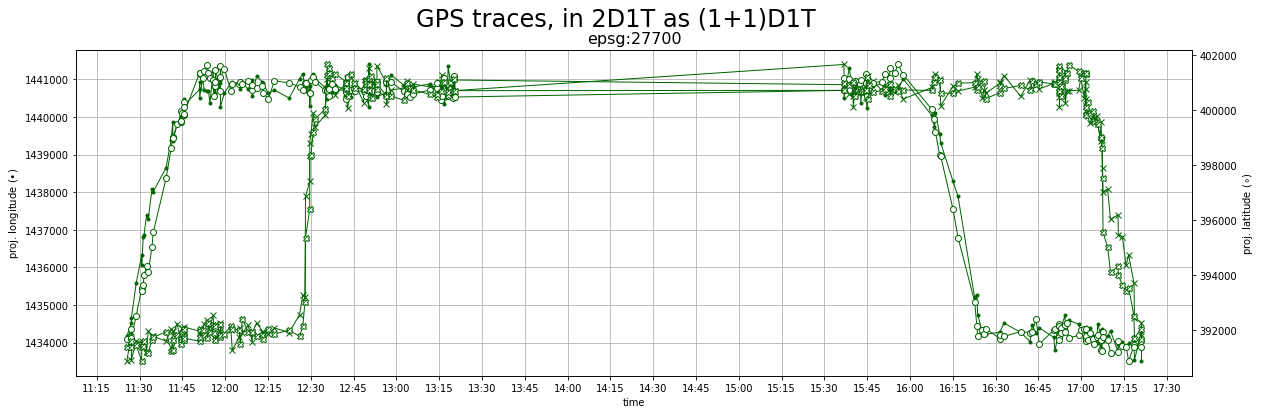

In [108]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax= plt.subplots(1,1, figsize=[20,6])

axt = ax.twinx()

offset = int(nprojx.size*.10)


ax.plot(ntime, nprojx, '.-', color=colors[n%len_colors], lw=1)
axt.plot(ntime, nprojy, 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    
ax.plot(ntime[::], nprojx[::-1], 'x-', color=colors[n%len_colors], lw=1)
axt.plot(ntime[::], nprojy[::-1], 'X-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [109]:
df.head()

time   timestamp        lat        lon  dtime
0 2018-08-14 11:24:55+00:00  1534245895  52.431062  13.258998      0
1 2018-08-14 11:25:01+00:00  1534245901  52.431157  13.259050      6
2 2018-08-14 11:25:07+00:00  1534245907  52.431122  13.259030     12
3 2018-08-14 11:25:13+00:00  1534245913  52.431152  13.259037     18
4 2018-08-14 11:25:19+00:00  1534245919  52.431155  13.259055     24

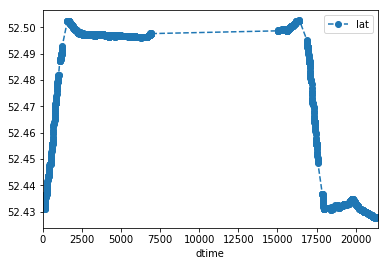

In [111]:
df.plot(x='dtime',y='lat', marker='o', linestyle='--')

In [115]:
df_c = df.copy()

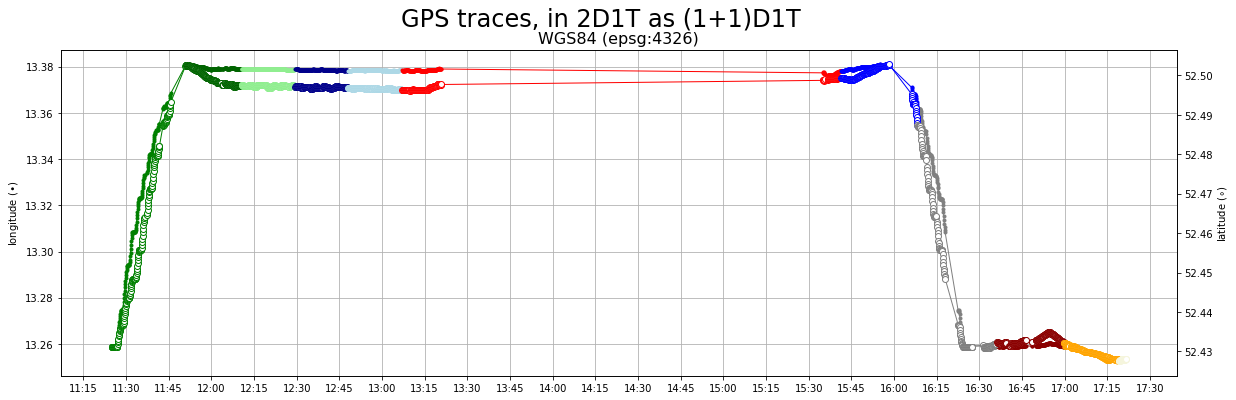

In [284]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax = plt.subplots(1,1, figsize=[20,6])


#axs = axs.flatten()

#ax = axs

axt = ax.twinx()

offset = 200

for n in range(11):
    nn = n*offset
    nnn = (n+1)*offset+1

    ax.plot(df.time.values[nn:nnn], df.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df.time.values[nn:nnn], df.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_minor_locator(locator)    
#ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [149]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=12, control_scale=True) #

len_colors=len(colors)

lons = df_c.lon.values
lats = df_c.lat.values
coords = list(zip(lats,lons))
print(len(coords))
offset=200
labels=[]
for n in range(11):
    nn = n*offset
    nnn = (n+1)*offset+1
    print(nn,nnn,len(coco))
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    labels.extend((len(coco))*[color])
    folium.PolyLine(coco, color=color).add_to(m)    
m    

2027
0 201 27
200 401 201
400 601 201
600 801 201
800 1001 201
1000 1201 201
1200 1401 201
1400 1601 201
1600 1801 201
1800 2001 201
2000 2201 201


In [145]:
df_c.shape

(2027, 5)

In [146]:
len(labels)

2037

In [139]:
aaa=range(10)

In [141]:
len(aaa[1:5])

4

In [156]:
df_c['labels'] = labels[:2027]

In [166]:
df_c.loc[2000::,['labels']]

labels
2000  orange
2001  orange
2002  orange
2003  orange
2004  orange
2005  orange
2006  orange
2007  orange
2008  orange
2009  orange
2010   beige
2011   beige
2012   beige
2013   beige
2014   beige
2015   beige
2016   beige
2017   beige
2018   beige
2019   beige
2020   beige
2021   beige
2022   beige
2023   beige
2024   beige
2025   beige
2026   beige

In [181]:
lons = df_c.lon.values
lats = df_c.lat.values
coords = list(zip(lats,lons))

In [183]:
home_home_coords = (lats[-100:].mean(),lons[-100:].mean())

In [193]:
m = folium.Map(location=home_home_coords, width='60%', height='100%', top='0%',
                   zoom_start=17, control_scale=True) #

len_colors=len(colors)

lons = df_c.lon.values
lats = df_c.lat.values
coords = list(zip(lats,lons))
print(len(coords))
#195
# 22
coords = coords[-22:][::-1] + coords[-195:][::-1] + coords
print(len(coords))
offset=200
#labels=[]
for n in range(12):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    #print(nn,nnn,len(coco), color)    
    #labels.extend((len(coco))*[color])
    folium.PolyLine(coco, color=color).add_to(m)    
m    

2027
2244


In [218]:
df_c = df.copy()

df_c['tdiff'] = df_c.dtime.diff()

df_c['tdiff'].fillna(0, inplace=True)

df_c.shape

(2027, 6)

In [225]:
2027-195

1832

In [236]:
df_1 = pd.concat(3*[df_c.loc[2007:,:]]+[df_c.loc[1832:,:]]+[df_c])

In [239]:
df_1.head(80)

time   timestamp        lat        lon  dtime  tdiff
2007 2018-08-14 17:19:45+00:00  1534267185  52.427923  13.252973  21290    6.0
2008 2018-08-14 17:19:51+00:00  1534267191  52.427923  13.252973  21296    6.0
2009 2018-08-14 17:19:56+00:00  1534267196  52.427967  13.252907  21301    5.0
2010 2018-08-14 17:20:02+00:00  1534267202  52.428013  13.252742  21307    6.0
2011 2018-08-14 17:20:08+00:00  1534267208  52.428013  13.252742  21313    6.0
2012 2018-08-14 17:20:14+00:00  1534267214  52.428013  13.252742  21319    6.0
2013 2018-08-14 17:20:20+00:00  1534267220  52.428052  13.252930  21325    6.0
2014 2018-08-14 17:20:26+00:00  1534267226  52.427955  13.253132  21331    6.0
2015 2018-08-14 17:20:31+00:00  1534267231  52.427955  13.253132  21336    5.0
2016 2018-08-14 17:20:36+00:00  1534267236  52.427955  13.253132  21341    5.0
2017 2018-08-14 17:20:42+00:00  1534267242  52.427955  13.253132  21347    6.0
2018 2018-08-14 17:20:48+00:00  1534267248  52.427955  13.253132  21353    6.0
2019 2018-08-14 17:20:54+00:00  1534267254  52.427943  13.253142  21359    6.0
2020 2018-08-14 17:21:00+00:00  1534267260  52.427927  13.253148  21365    6.0
2021 2018-08-14 17:21:06+00:00  1534267266  52.427927  13.253148  21371    6.0
2022 2018-08-14 17:21:12+00:00  1534267272  52.428002  13.253130  21377    6.0
2023 2018-08-14 17:21:17+00:00  1534267277  52.428000  13.253160  21382    5.0
2024 2018-08-14 17:21:23+00:00  1534267283  52.428023  13.253160  21388    6.0
2025 2018-08-14 17:21:28+00:00  1534267288  52.428023  13.253160  21393    5.0
2026 2018-08-14 17:21:36+00:00  1534267296  52.428023  13.253160  21401    8.0
2007 2018-08-14 17:19:45+00:00  1534267185  52.427923  13.252973  21290    6.0
2008 2018-08-14 17:19:51+00:00  1534267191  52.427923  13.252973  21296    6.0
2009 2018-08-14 17:19:56+00:00  1534267196  52.427967  13.252907  21301    5.0
2010 2018-08-14 17:20:02+00:00  1534267202  52.428013  13.252742  21307    6.0
2011 2018-08-14 17:20:08+00:00  1534267208  52.428013  13.252742  21313    6.0
2012 2018-08-14 17:20:14+00:00  1534267214  52.428013  13.252742  21319    6.0
2013 2018-08-14 17:20:20+00:00  1534267220  52.428052  13.252930  21325    6.0
2014 2018-08-14 17:20:26+00:00  1534267226  52.427955  13.253132  21331    6.0
2015 2018-08-14 17:20:31+00:00  1534267231  52.427955  13.253132  21336    5.0
2016 2018-08-14 17:20:36+00:00  1534267236  52.427955  13.253132  21341    5.0
...                        ...         ...        ...        ...    ...    ...
2017 2018-08-14 17:20:42+00:00  1534267242  52.427955  13.253132  21347    6.0
2018 2018-08-14 17:20:48+00:00  1534267248  52.427955  13.253132  21353    6.0
2019 2018-08-14 17:20:54+00:00  1534267254  52.427943  13.253142  21359    6.0
2020 2018-08-14 17:21:00+00:00  1534267260  52.427927  13.253148  21365    6.0
2021 2018-08-14 17:21:06+00:00  1534267266  52.427927  13.253148  21371    6.0
2022 2018-08-14 17:21:12+00:00  1534267272  52.428002  13.253130  21377    6.0
2023 2018-08-14 17:21:17+00:00  1534267277  52.428000  13.253160  21382    5.0
2024 2018-08-14 17:21:23+00:00  1534267283  52.428023  13.253160  21388    6.0
2025 2018-08-14 17:21:28+00:00  1534267288  52.428023  13.253160  21393    5.0
2026 2018-08-14 17:21:36+00:00  1534267296  52.428023  13.253160  21401    8.0
1832 2018-08-14 17:03:01+00:00  1534266181  52.430882  13.259575  20286    5.0
1833 2018-08-14 17:03:07+00:00  1534266187  52.430882  13.259575  20292    6.0
1834 2018-08-14 17:03:13+00:00  1534266193  52.430882  13.259575  20298    6.0
1835 2018-08-14 17:03:18+00:00  1534266198  52.430882  13.259575  20303    5.0
1836 2018-08-14 17:03:24+00:00  1534266204  52.430825  13.259420  20309    6.0
1837 2018-08-14 17:03:30+00:00  1534266210  52.430817  13.259387  20315    6.0
1838 2018-08-14 17:03:36+00:00  1534266216  52.430817  13.259387  20321    6.0
1839 2018-08-14 17:03:41+00:00  1534266221  52.430785  13.259240  20326    5.0
1840 2018-08-14 17:03:47+00:00  1534266227  52.430785  13.259240  20332    6

In [278]:
df_1 = pd.concat(20*[df_c.loc[2008:,:].iloc[::-1]]+[df_c.loc[1832:,:].iloc[::-1]]+[df_c]+10*[df_c.loc[2008:,:]])

m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=12, control_scale=True) #

print(df_c.shape)
len_colors=len(colors)

lons = df_1.lon.values
lats = df_1.lat.values
coords = list(zip(lats,lons))
print(len(coords))
offset=200
for n in range(5):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[(n+1)%len_colors]
    
    print(nn,nnn,len(coco),color)

    folium.PolyLine(coco, color=color).add_to(m)    
m    



(2027, 6)
2792
0 201 201 darkgreen
200 401 201 lightgreen
400 601 201 darkblue
600 801 201 lightblue
800 1001 201 red


In [279]:
df_1.loc[0,'tdiff'] = 6.0

df_1.reset_index(drop=True, inplace=True)

df_1.loc[0,'tdiff'] = 0.0

df_1['dtime'] = np.cumsum(df_1.tdiff.values)

In [273]:
df_1.head()

time   timestamp        lat       lon  dtime  tdiff
0 2018-08-14 17:21:36+00:00  1534267296  52.428023  13.25316    0.0    0.0
1 2018-08-14 17:21:28+00:00  1534267288  52.428023  13.25316    5.0    5.0
2 2018-08-14 17:21:23+00:00  1534267283  52.428023  13.25316   11.0    6.0
3 2018-08-14 17:21:17+00:00  1534267277  52.428000  13.25316   16.0    5.0
4 2018-08-14 17:21:12+00:00  1534267272  52.428002  13.25313   22.0    6.0

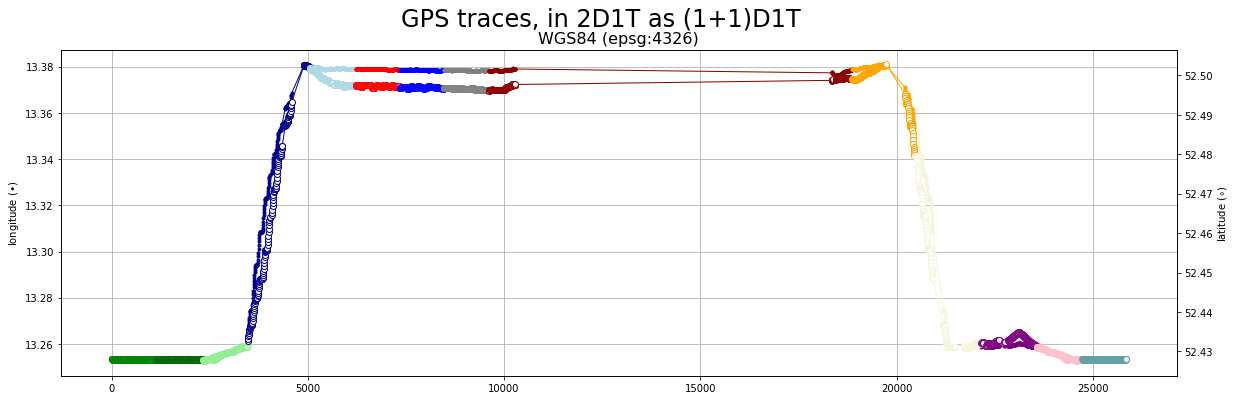

In [288]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax = plt.subplots(1,1, figsize=[20,6])


#axs = axs.flatten()

#ax = axs

axt = ax.twinx()

offset = 200

for n in range(21):
    nn = n*offset
    nnn = (n+1)*offset+1

    ax.plot(df_1.dtime.values[nn:nnn], df_1.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df_1.dtime.values[nn:nnn], df_1.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_minor_locator(locator)    
#ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [291]:
df_1[df_1["tdiff"]>1000]

time   timestamp        lat       lon    dtime  \
1717 2018-08-14 15:35:05+00:00  1534260905  52.498732  13.37735  18348.0   

       tdiff  
1717  8064.0

In [316]:
missing = df_1.loc[1716:1760,['lat','lon']].values.tolist()

In [317]:
len(missing)

45

In [305]:
mmm=474
2*6*mmm + 5*mmm

8058

In [321]:
from random import sample, shuffle

In [322]:
missing_pairs = df_1.loc[1716:1760,['lat','lon']].values

In [323]:
missing_choice = np.random.choice(np.arange(missing_pairs.shape[0]), size=474)

In [325]:
missing_sample = missing_pairs[missing_choice]

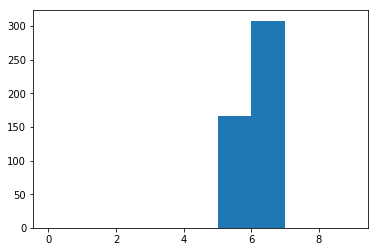

In [346]:
denom  = 2750
fivesix = np.random.choice(np.arange(5,7), size=474,p=np.array([1000/denom, 1750/denom]))
plt.hist(fivesix, bins=range(10));

In [349]:
df_2 = df_1[['lat','lon', 'tdiff']].copy()

In [350]:
df_2.head()

lat       lon  tdiff
0  52.428023  13.25316    0.0
1  52.428023  13.25316    5.0
2  52.428023  13.25316    6.0
3  52.428000  13.25316    5.0
4  52.428002  13.25313    6.0

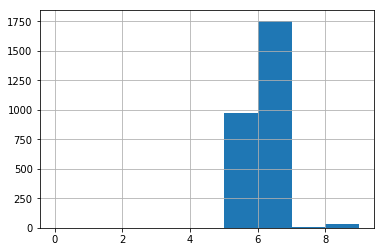

In [297]:
df_1.tdiff.hist(bins=range(10))

In [358]:
fivesix.shape

(474,)

In [361]:
df_3 = pd.DataFrame(data=np.hstack([missing_sample,fivesix.reshape(-1,1)]), columns=df_2.columns )

In [390]:
df_4 = pd.concat([df_2.loc[:1716]]+[df_2.loc[1718:]])

In [391]:
df_4.reset_index(drop=True, inplace=True)
df_4['dtime'] = np.cumsum(df_4.tdiff.values)

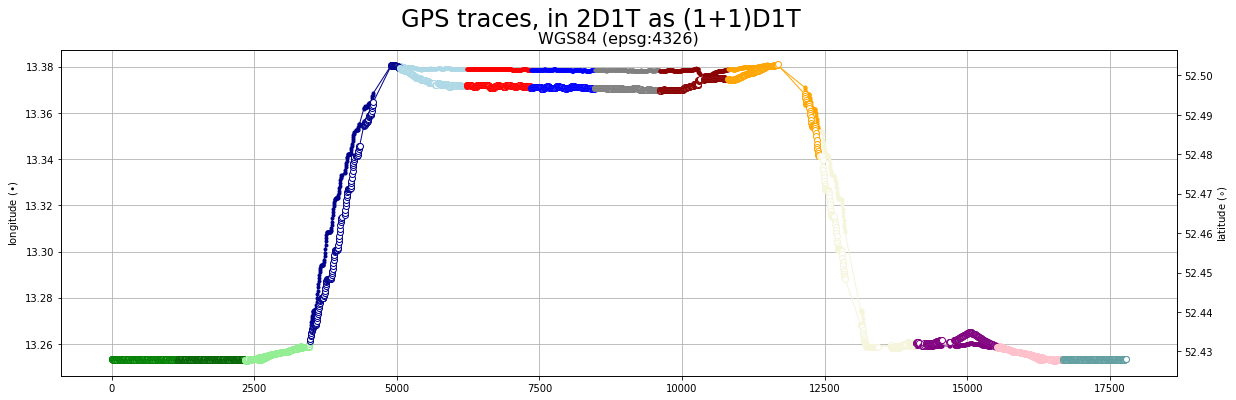

In [392]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax = plt.subplots(1,1, figsize=[20,6])


#axs = axs.flatten()

#ax = axs

axt = ax.twinx()

offset = 200

for n in range(21):
    nn = n*offset
    nnn = (n+1)*offset+1

    ax.plot(df_4.dtime.values[nn:nnn], df_4.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df_4.dtime.values[nn:nnn], df_4.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_minor_locator(locator)    
#ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [393]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=12, control_scale=True) #

print(df_c.shape)
len_colors=len(colors)

lons = df_4.lon.values
lats = df_4.lat.values
coords = list(zip(lats,lons))
print(len(coords))
offset=200
for n in range(15):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[(n+1)%len_colors]
    
    print(nn,nnn,len(coco),color)

    folium.PolyLine(coco, color=color).add_to(m)    
m

(2027, 6)
2791
0 201 201 darkgreen
200 401 201 lightgreen
400 601 201 darkblue
600 801 201 lightblue
800 1001 201 red
1000 1201 201 blue
1200 1401 201 gray
1400 1601 201 darkred
1600 1801 201 orange
1800 2001 201 beige
2000 2201 201 purple
2200 2401 201 pink
2400 2601 201 cadetblue
2600 2801 191 lightgray
2800 3001 0 black


In [396]:
df_1.timestamp.min()

1534245895

In [397]:
df_1.time.min()

Timestamp('2018-08-14 11:24:55+0000', tz='SimpleTZ("Z")')

In [405]:
df_1.time.values[0]

numpy.datetime64('2018-08-14T17:21:36.000000000')

In [398]:
df_1.timestamp.min()-3500

1534242395

In [407]:
datetime.datetime.fromtimestamp(1534245895), datetime.datetime.fromtimestamp(1534242395)

(datetime.datetime(2018, 8, 14, 13, 24, 55),
 datetime.datetime(2018, 8, 14, 12, 26, 35))

In [408]:
df_4.head()

lat       lon  tdiff  dtime
0  52.428023  13.25316    0.0    0.0
1  52.428023  13.25316    5.0    5.0
2  52.428023  13.25316    6.0   11.0
3  52.428000  13.25316    5.0   16.0
4  52.428002  13.25313    6.0   22.0

In [418]:
df_4['timestamp']  = df_4['dtime']+1534242395

In [419]:
df_4['time'] = pd.to_datetime(df_4['timestamp'],unit='s')

In [423]:
df_4 = df_4[['time', 'timestamp', 'lat', 'lon', 'dtime','tdiff']]

In [424]:
df_4

time     timestamp        lat        lon    dtime  tdiff
0    2018-08-14 10:26:35  1.534242e+09  52.428023  13.253160      0.0    0.0
1    2018-08-14 10:26:40  1.534242e+09  52.428023  13.253160      5.0    5.0
2    2018-08-14 10:26:46  1.534242e+09  52.428023  13.253160     11.0    6.0
3    2018-08-14 10:26:51  1.534242e+09  52.428000  13.253160     16.0    5.0
4    2018-08-14 10:26:57  1.534242e+09  52.428002  13.253130     22.0    6.0
5    2018-08-14 10:27:03  1.534242e+09  52.427927  13.253148     28.0    6.0
6    2018-08-14 10:27:09  1.534242e+09  52.427927  13.253148     34.0    6.0
7    2018-08-14 10:27:15  1.534242e+09  52.427943  13.253142     40.0    6.0
8    2018-08-14 10:27:21  1.534242e+09  52.427955  13.253132     46.0    6.0
9    2018-08-14 10:27:27  1.534242e+09  52.427955  13.253132     52.0    6.0
10   2018-08-14 10:27:32  1.534242e+09  52.427955  13.253132     57.0    5.0
11   2018-08-14 10:27:37  1.534242e+09  52.427955  13.253132     62.0    5.0
12   2018-08-14 10:27:43  1.534242e+09  52.427955  13.253132     68.0    6.0
13   2018-08-14 10:27:49  1.534242e+09  52.428052  13.252930     74.0    6.0
14   2018-08-14 10:27:55  1.534242e+09  52.428013  13.252742     80.0    6.0
15   2018-08-14 10:28:01  1.534242e+09  52.428013  13.252742     86.0    6.0
16   2018-08-14 10:28:07  1.534242e+09  52.428013  13.252742     92.0    6.0
17   2018-08-14 10:28:12  1.534242e+09  52.427967  13.252907     97.0    5.0
18   2018-08-14 10:28:18  1.534242e+09  52.427923  13.252973    103.0    6.0
19   2018-08-14 10:28:26  1.534243e+09  52.428023  13.253160    111.0    8.0
20   2018-08-14 10:28:31  1.534243e+09  52.428023  13.253160    116.0    5.0
21   2018-08-14 10:28:37  1.534243e+09  52.428023  13.253160    122.0    6.0
22   2018-08-14 10:28:42  1.534243e+09  52.428000  13.253160    127.0    5.0
23   2018-08-14 10:28:48  1.534243e+09  52.428002  13.253130    133.0    6.0
24   2018-08-14 10:28:54  1.534243e+09  52.427927  13.253148    139.0    6.0
25   2018-08-14 10:29:00  1.534243e+09  52.427927  13.253148    145.0    6.0
26   2018-08-14 10:29:06  1.534243e+09  52.427943  13.253142    151.0    6.0
27   2018-08-14 10:29:12  1.534243e+09  52.427955  13.253132    157.0    6.0
28   2018-08-14 10:29:18  1.534243e+09  52.427955  13.253132    163.0    6.0
29   2018-08-14 10:29:23  1.534243e+09  52.427955  13.253132    168.0    5.0
...                  ...           ...        ...        ...      ...    ...
2761 2018-08-14 15:20:09  1.534260e+09  52.427955  13.253132  17614.0    5.0
2762 2018-08-14 15:20:15  1.534260e+09  52.427955  13.253132  17620.0    6.0
2763 2018-08-14 15:20:21  1.534260e+09  52.427955  13.253132  17626.0    6.0
2764 2018-08-14 15:20:27  1.534260e+09  52.427943  13.253142  17632.0    6.0
2765 2018-08-14 15:20:33  1.534260e+09  52.427927  13.253148  17638.0    6.0
2766 2018-08-14 15:20:39  1.534260e+09  52.427927  13.253148  17644.0    6.0
2767 2018-08-14 15:20:45  1.534260e+09  52.428002  13.253130  17650.0    6.0
2768 2018-08-14 15:20:50  1.534260e+09  52.428000  13.253160  17655.0    5.0
2769 2018-08-14 15:20:56  1.534260e+09  52.428023  13.253160  17661.0    6.0
2770 2018-08-14 15:21:01  1.534260e+09  52.428023  13.253160  17666.0    5.0
2771 2018-08-14 15:21:09  1.534260e+09  52.428023  13.253160  17674.0    8.0
2772 2018-08-14 15:21:15  1.534260e+09  52.427923  13.252973  17680.0    6.0
2773 2018-08-14 15:21:20  1.534260e+09  52.427967  13.252907  17685.0    5.0
2774 2018-08-14 15:21:26  1.534260e+09  52.428013  13.252742  17691.0    6.0
2775 2018-08-14 15:21:32  1.534260e+09  52.428013  13.252742  17697.0    6.0
2776 2018-08-14 15:21:38  1.534260e+09  52.428013  13.252742  17703.0    6.0
2777 2018-08-14 15:21:44  1.534260e+09  52.428052  13.252930  17709.0    6.0
2778 2018-08-14 15:21:50  1.534260e+09  52.427955  13.253132  17715.0    6.0
2779 2018-08-14 15:21:55  1.534260e+09  52.427955  13.253132  17720.0    5.0
2780 2018-08-14 15:22:00  1.534260e+09  52.427955  13.253132  17725.0    5.0
2781 2018-08-14 

In [425]:
df_4.time.count()

2791

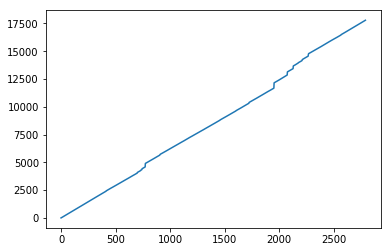

In [445]:
plt.plot(df_4.dtime)

In [476]:
projx, projy = proj.transform(crs_wgs, crs_bng, df_4["lon"].values, df_4["lat"].values)
mask = get_mask_with_duplicates(df_4.time.values, 0.15, 0.15, True)
nprojx = map_array(get_add_noise(200.0))(projx[mask])
nprojy = map_array(get_add_noise(200.0))(projy[mask])

62
Counter({1: 23, 2: 8, 3: 5, 4: 2})
freq 38 62 38

417 355 62 14.87


In [499]:
ntime = df_4.time.values[mask].copy()

In [477]:
nlons, nlats = proj.transform(crs_bng, crs_wgs, nprojx, nprojy)

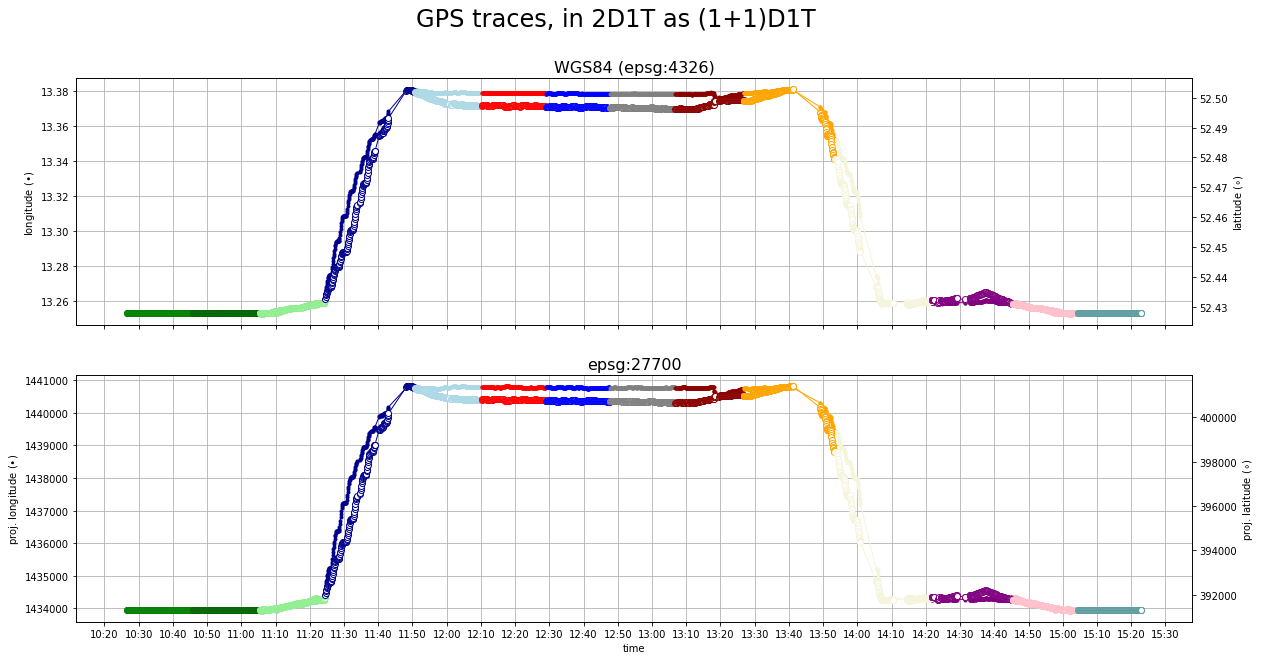

In [478]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df_4.time.values[nn:nnn], df_4.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df_4.time.values[nn:nnn], df_4.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df_4.time.values[nn:nnn], projx[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df_4.time.values[nn:nnn], projy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

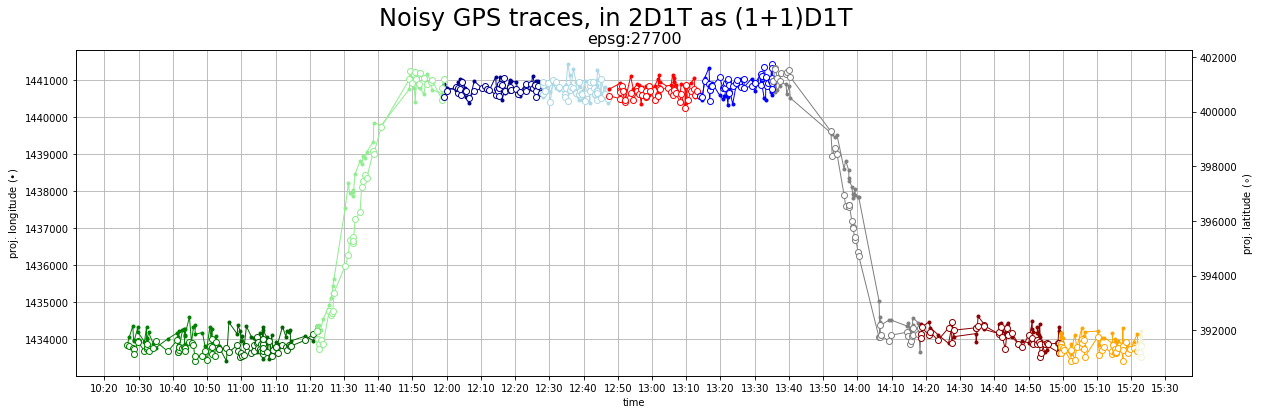

In [479]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax= plt.subplots(1,1, figsize=[20,6])

axt = ax.twinx()

offset = int(nprojx.size*.10)

for n in range(50):
    nn = n*offset
    nnn = (n+1)*offset+1

    ax.plot(ntime[nn:nnn], nprojx[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(ntime[nn:nnn], nprojy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('Noisy GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

# then cast your geographic coordinate pair to the projected system
nlons, nlats = proj.transform(crs_bng, crs_wgs, nprojx, nprojy)

In [480]:
nlons.shape

(417,)

In [481]:
df_4.time.shape

(2791,)

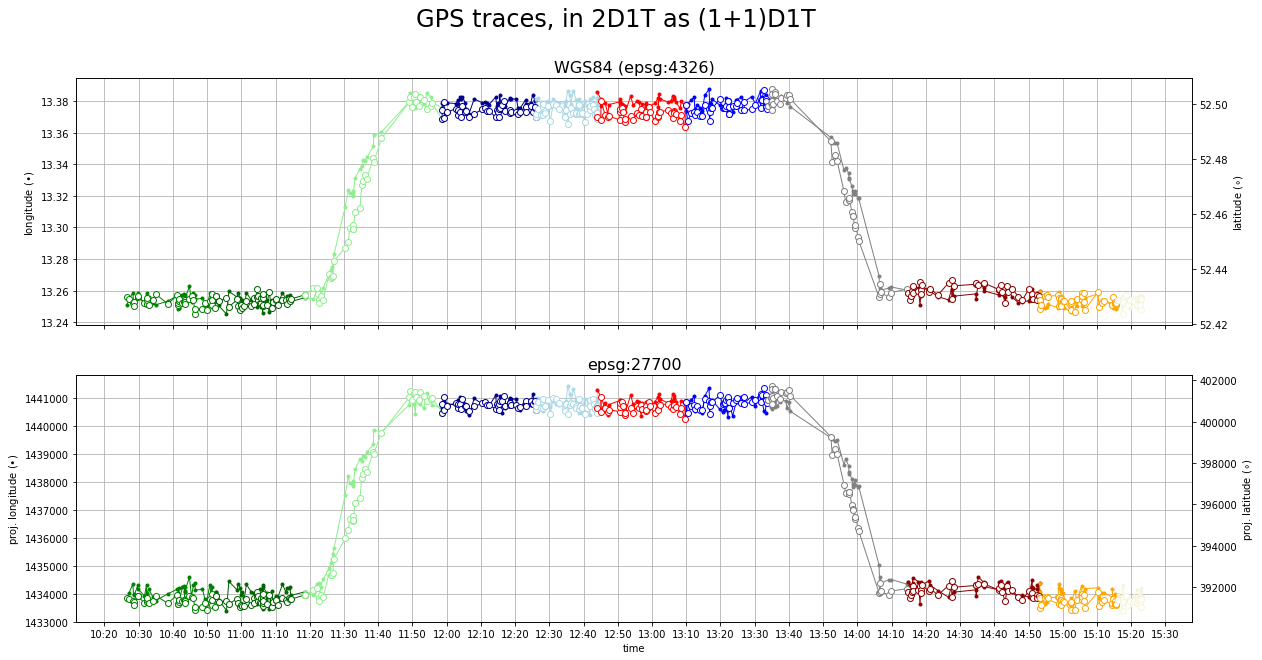

In [482]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

offset=40
range_ =51
for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]

    ax.plot(ntime[nn:nnn], nlons[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(ntime[nn:nnn], nlats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(ntime[nn:nnn], nprojx[nn:nnn], '.-', color=color, lw=1)
    axt.plot(ntime[nn:nnn], nprojy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [522]:
m = folium.Map(location=home_coords, width='60%', height='50%', top='0%',
                   zoom_start=12, tiles='CartoDBpositron', control_scale=True)

len_colors=len(colors)

lons = nlons
lats = nlats
coords = list(zip(lats,lons))

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

In [442]:
df_4[['time', 'timestamp', 'lat', 'lon','tdiff']].to_csv('2778884_modified.csv',index=False)

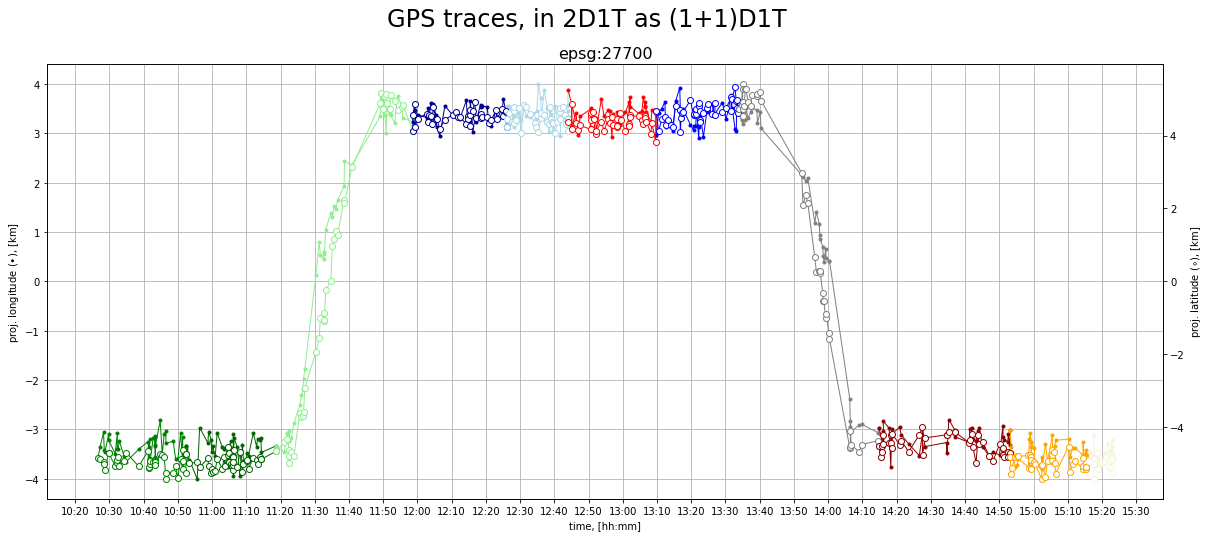

In [492]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, ax = plt.subplots(1,1, figsize=[20,8])

axt = ax.twinx()

nprojx_med = (nprojx.max()+nprojx.min())/2 #np.median(nprojx)
nprojy_med = (nprojy.max()+nprojy.min())/2 #np.median(nprojy)

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(ntime[nn:nnn], (nprojx[nn:nnn]-nprojx_med)/1000., '.-', color=color, lw=1)
    axt.plot(ntime[nn:nnn], (nprojy[nn:nnn]-nprojy_med)/1000., 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
ax.set_xlabel("time, [hh:mm]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [500]:
ntstamp = df_4.timestamp.values[mask].copy()

In [513]:
df_n = pd.DataFrame({'time':ntime, 'timestamp':ntstamp, 'plon':nprojy, 'plat':nprojy})

In [514]:
df_n.head()

time     timestamp           plon           plat
0 2018-08-14 10:26:35  1.534242e+09  391458.075158  391458.075158
1 2018-08-14 10:27:15  1.534242e+09  391429.521957  391429.521957
2 2018-08-14 10:28:18  1.534242e+09  391354.302437  391354.302437
3 2018-08-14 10:28:31  1.534243e+09  391297.341976  391297.341976
4 2018-08-14 10:28:42  1.534243e+09  391129.103563  391129.103563

In [515]:
df_n['nplon'] = (nprojx-nprojx_med)/1000.
df_n['nplat'] = (nprojy-nprojy_med)/1000.
df_n['nstamp'] = df_n.timestamp-df_n.timestamp.min()

In [516]:
df_n.head()

time     timestamp           plon           plat     nplon  \
0 2018-08-14 10:26:35  1.534242e+09  391458.075158  391458.075158 -3.609888   
1 2018-08-14 10:27:15  1.534242e+09  391429.521957  391429.521957 -3.366210   
2 2018-08-14 10:28:18  1.534242e+09  391354.302437  391354.302437 -3.060681   
3 2018-08-14 10:28:31  1.534243e+09  391297.341976  391297.341976 -3.427121   
4 2018-08-14 10:28:42  1.534243e+09  391129.103563  391129.103563 -3.464079   

      nplat  nstamp  
0 -4.841245     0.0  
1 -4.869798    40.0  
2 -4.945017   103.0  
3 -5.001978   116.0  
4 -5.170216   127.0

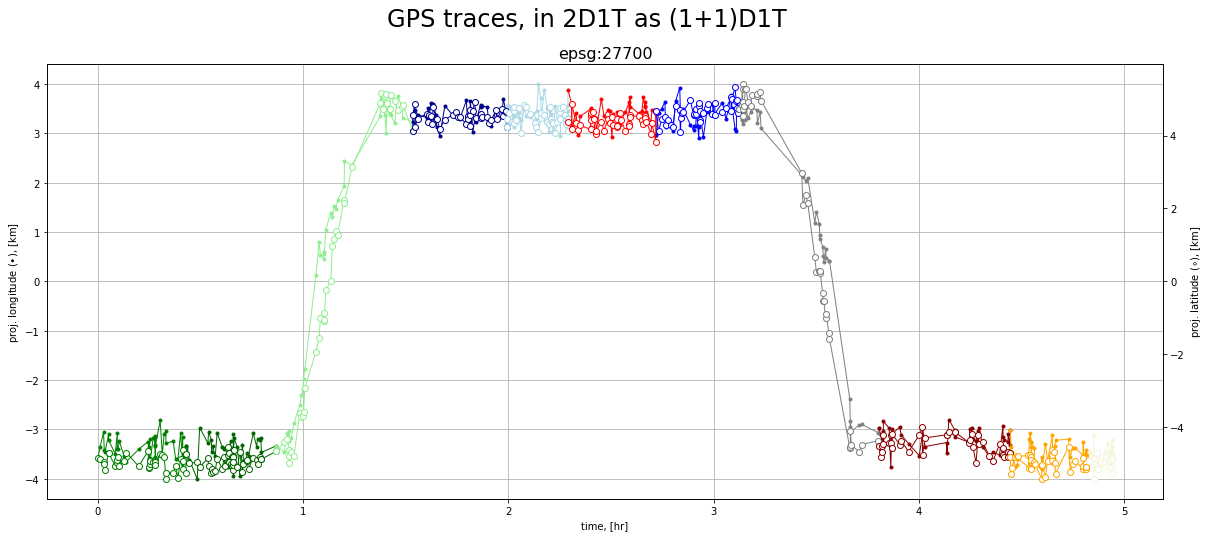

In [517]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

axt = ax.twinx()

nprojx_med = (nprojx.max()+nprojx.min())/2 #np.median(nprojx)
nprojy_med = (nprojy.max()+nprojy.min())/2 #np.median(nprojy)

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot((ntstamp[nn:nnn]-ntstamp.min())/(3600), (nprojx[nn:nnn]-nprojx_med)/1000., '.-', color=color, lw=1)
    axt.plot((ntstamp[nn:nnn]-ntstamp.min())/(3600), (nprojy[nn:nnn]-nprojy_med)/1000., 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
ax.set_xlabel("time, [hr]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [518]:
df_n.head()

time     timestamp           plon           plat     nplon  \
0 2018-08-14 10:26:35  1.534242e+09  391458.075158  391458.075158 -3.609888   
1 2018-08-14 10:27:15  1.534242e+09  391429.521957  391429.521957 -3.366210   
2 2018-08-14 10:28:18  1.534242e+09  391354.302437  391354.302437 -3.060681   
3 2018-08-14 10:28:31  1.534243e+09  391297.341976  391297.341976 -3.427121   
4 2018-08-14 10:28:42  1.534243e+09  391129.103563  391129.103563 -3.464079   

      nplat  nstamp  
0 -4.841245     0.0  
1 -4.869798    40.0  
2 -4.945017   103.0  
3 -5.001978   116.0  
4 -5.170216   127.0

In [520]:
df_n[['time', 'timestamp', 'plat', 'plon']].to_csv('2778884_projected.csv',index=False)

---

## Start with trace

In [528]:
df_5 = pd.DataFrame({'time':ntime, 'timestamp':ntstamp, 'lon':nlons, 'lat':nlats})

In [530]:
df_5[['time', 'timestamp', 'lat', 'lon']].to_csv('2778884_noise.csv',index=False)

In [543]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=13, tiles='CartoDBpositron', control_scale=True)

len_colors=len(colors)

lons = df_5.lon.values
lats = df_5.lat.values
coords = list(zip(lats,lons))

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

## Apply projections and plot in 2D1T

In [531]:
plons, plats = proj.transform(crs_wgs, crs_bng, lons, lats)

In [533]:
times = df_5.time.values

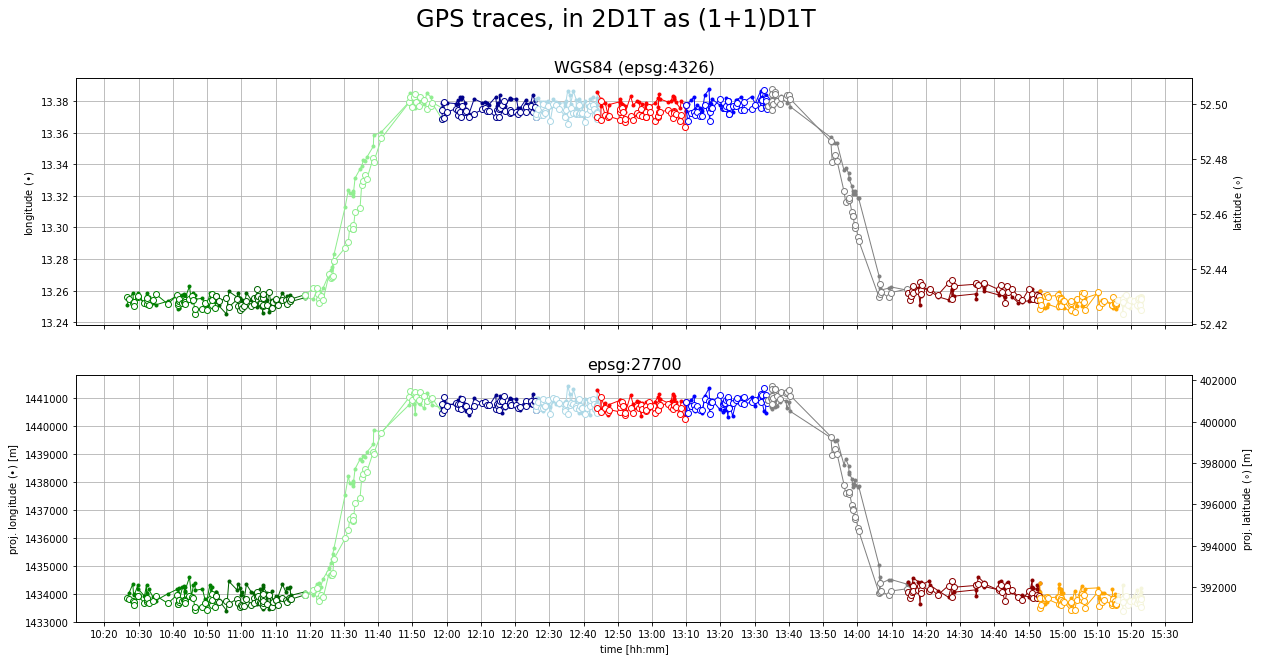

In [534]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

offset=40
range_ =51
for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]

    ax.plot(times[nn:nnn], lons[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(times[nn:nnn], lats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(times[nn:nnn], plons[nn:nnn], '.-', color=color, lw=1)
    axt.plot(times[nn:nnn], plats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$) [m]")
ax.set_ylabel(r"proj. longitude ($\bullet$) [m]")
ax.set_xlabel("time [hh:mm]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

## Shift & Scale transforms

In [540]:
from matplotlib import ticker

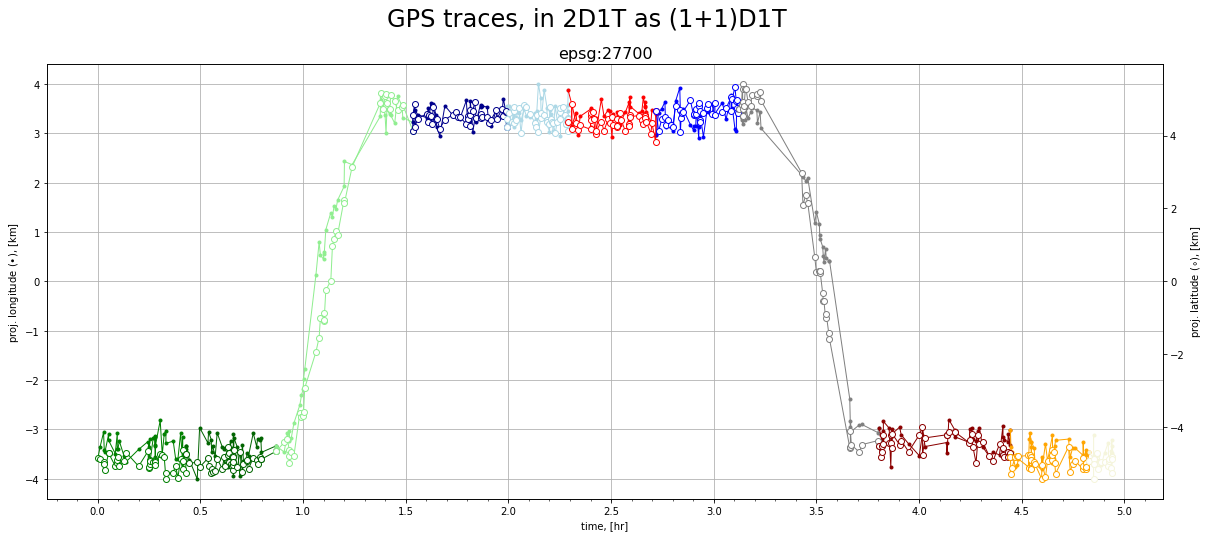

In [544]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

axt = ax.twinx()

nplons = (plons-(plons.max()+plons.min())/2)/1000. #np.median(plon)
nplats = (plats-(plats.max()+plats.min())/2)/1000. #np.median(plat)
stamps = df_5.timestamp.values
stamps = (stamps-stamps.min())/3600.

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(stamps[nn:nnn], nplons[nn:nnn], '.-', color=color, lw=1)
    axt.plot(stamps[nn:nnn], nplats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))  

axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
ax.set_xlabel("time, [hr]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

In [553]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

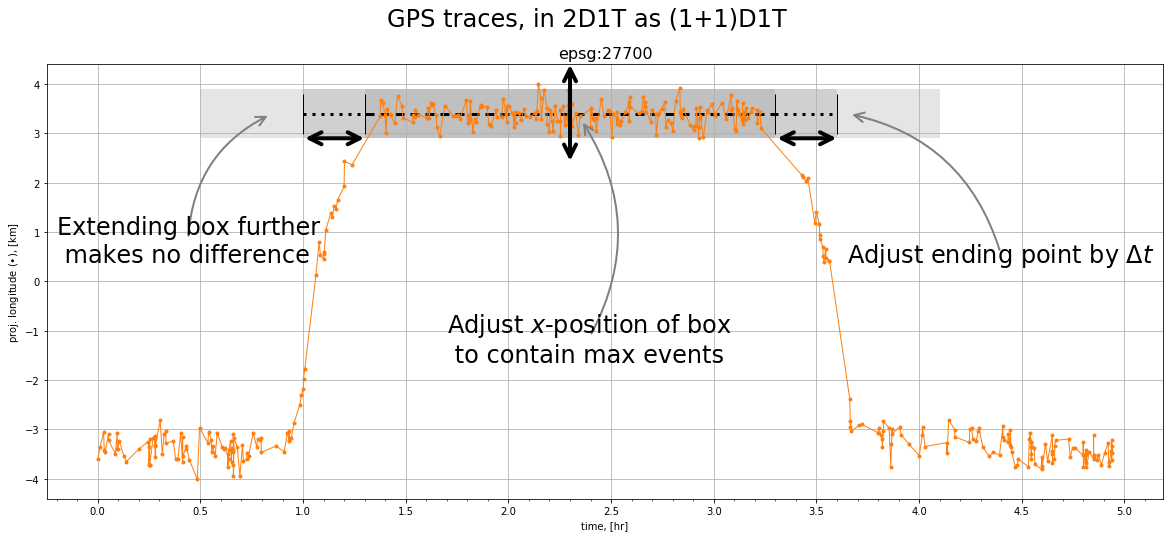

In [613]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

eps = 0.5
begin = 1.3
begin_buff = begin-0.3
end = 3.3
end_buff = end+0.3

loc = 3.4

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)
ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

ax.plot(stamps, nplons, '.-', color='C1', lw=1, label='raw')

    
# Boxes
rect_small = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_middle = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_big = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)
box_dict = dict(facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)
ax.add_collection(PatchCollection([rect_big], **box_dict))
ax.add_collection(PatchCollection([rect_middle], **box_dict))
ax.add_collection(PatchCollection([rect_small], **box_dict))


# Double arrows
arrowprops=dict(arrowstyle="<->", 
                shrinkA=0.5,
                mutation_scale=30.0,
                connectionstyle="arc3", linewidth=4.0)
arrowcentery = loc
arrowcenterx = 2.3
arrowcenterh = 2*eps
ax.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), xytext=(arrowcenterx, arrowcentery+arrowcenterh),
             arrowprops=arrowprops)

dt_arrowcentery = eps
ax.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), xytext=(begin, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

ax.annotate("", xy=(end, arrowcentery-dt_arrowcentery), xytext=(end_buff, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

# Annotations
arrowprops=dict(arrowstyle="->", color="0.5",
                shrinkA=5, shrinkB=5,
                patchA=None, patchB=None,
                connectionstyle="arc3,rad=-0.3", linewidth=2.0)

delta_t_texty = 0.4

mid_point = lambda x1,x2: 0.5*(x1+x2)

anno_dict = dict(fontsize= 24,textcoords='data', xycoords='data')
ax.annotate("Extending box further\n makes no difference",
            xy=(mid_point(begin,begin_buff)-0.3, 3.4),
            xytext=(begin-1.5,delta_t_texty),
            **anno_dict, arrowprops=arrowprops)

arrowprops['connectionstyle']="arc3,rad=0.3"


ax.annotate(r"Adjust ending point by $\Delta t$",
            xy=(mid_point(end,end_buff)+0.2, 3.4),
            xytext=(end+0.35, delta_t_texty),
            **anno_dict, arrowprops=arrowprops)

ax.annotate(s=r"Adjust $x$-position "+"of box\n to contain max events",
            xy=(arrowcenterx+0.05, arrowcentery-0.1),
            xytext=(arrowcenterx-0.6, arrowcentery-5.0),
            **anno_dict, arrowprops=arrowprops)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))  

axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
ax.set_xlabel("time, [hr]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid(visible=True)

fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);